In [71]:
import numpy as np
import pandas as pd
import scipy

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, GroupKFold, LeaveOneOut, LeaveOneGroupOut
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()


In [72]:
RANDOM = 42

ANTHROPOMETRY = ['person_clinic_weight', 'person_clinic_height','person_clinic_bmi','person_clinic_waist','person_clinic_hip',
                'person_clinic_waist2hip']

AGE = ['person_md_age']

SEX = ['person_md_sex']

CLINICAL_BIOCHEMESTRY = ['person_clinic_pulse_1', 'person_clinic_pulse_2', 'person_clinic_pulse_3',
                         'person_clinic_pulse_1_diastolic', 'person_clinic_pulse_2_diastolic', 'person_clinic_pulse_3_diastolic',
                         'person_clinic_pulse_1_systolic', 'person_clinic_pulse_2_systolic', 'person_clinic_pulse_3_systolic',
                         'person_affinity_il6', 'person_affinity_alt',  'person_affinity_chol',
                         'person_affinity_hdl', 'person_affinity_ldl',  'person_affinity_non_hdl',
                         'person_affinity_thr', 'person_affinity_tsh', 'person_pglu',   'person_trig', 'person_ins',
                         'person_cpep',   'person_hba1c',  'person_basophils', 'person_eosinophils',
                         'person_hb', 'person_lymphocytes', 'person_mch', 'person_mcv',
                         'person_monocytes', 'person_neutrophils',   'person_nrbc', 'person_pcv',  'person_plt',
                         'person_rbc',  'person_rdw','person_wbc']

MEAL_CONTEXT = [
    'previous_meal_carbohydrate', 'previous_meal_time_since', 'meal_carb_3hr_bef', 'meal_carb_6hr_bef',
    'meal_carb_9hr_bef', 'meal_carb_12hr_bef', 'activity_post_meal_mvpa', 'activity_pre_meal_mvpa',
    'activity_pre_24h_meal_mvpa', 'activity_post_meal_light', 'activity_pre_meal_light', 'activity_pre_24h_meal_light',
    'sleep_hours_since_wake_up', 'sleep_hours_to_next_onset', 'sleep_hours_duration', 'sleep_percentage_efficiency',
    'meal_baseline_difference', 'meal_norm_start_at_midnight']

MEAL_CONTENT = ['meal_fat2carbs', 'meal_calories','meal_carbohydrate','meal_fat','meal_protein', 'meal_fibre', 'meal_sugar']

OTHERS = ['meal_study','person_username', 'meal_has_set_meal', 'meal_set_meal']

ALL_FEAT = ANTHROPOMETRY + CLINICAL_BIOCHEMESTRY + AGE + SEX + MEAL_CONTEXT + MEAL_CONTENT
RESPONSES = ['meal_iauc', 'trig_rise_6h', 'cpep_rise_1h']

pearsonr_scorer = make_scorer(lambda x,y:scipy.stats.pearsonr(x,y)[0])

In [73]:
def bscore(estimator, whole_x, whole_y, btimes=100):
    '''
    finds the bootstrapped score and prints the result
    '''
    np.random.seed(RANDOM)
    scores = []
    for _ in tqdm(range(btimes)):
        idx = np.random.choice(len(whole_x), len(whole_x))
        x = whole_x.iloc[idx, :]
        y = whole_y[idx]
        scores.append(pearsonr_scorer(estimator, x, y))
    print('mean pearson R:', np.mean(scores))
    print('std  pearson R:', np.std(scores))

In [74]:
# Load datasets
meals_clean_df = pd.read_csv('./sample_meals.csv')
raw_microbiome_df = pd.read_csv('./sample_microbiome.csv')

In [75]:
# Perform feature reduction on microbiome before merging
df_bacteria = raw_microbiome_df.loc[:, raw_microbiome_df.columns.str.contains('Bacteria')]
pca_pipe = [('imputer', SimpleImputer(strategy='mean')),
            ('scale', StandardScaler(with_mean=True,
                                     with_std=True)),
            ('pca', PCA(n_components=10))
           ]
axer = Pipeline(pca_pipe)
pcadf = pd.DataFrame(axer.fit_transform(df_bacteria))
pcadf.columns = ['mb_pca_' + str(i) for i in range(len(pcadf.columns))]

In [76]:
# Create a copy of the microbiome dataframe with just the key identifiers
# This ensures we maintain the same index structure when joining
microbiome_key_cols = raw_microbiome_df[['person_username', 'meal_study']].copy()
microbiome_key_cols = microbiome_key_cols.join(pcadf)

In [77]:
# Now merge the PCA features with the original datasets
df_clean = meals_clean_df.merge(raw_microbiome_df, on=['person_username', 'meal_study'])
df_clean = df_clean.merge(microbiome_key_cols, on=['person_username', 'meal_study'])

In [78]:
# Split into UK and US datasets
df_uk = df_clean[df_clean.meal_study.isin(['PREDICT UK 1.0'])].reset_index(drop=True)
df_us = df_clean[df_clean.meal_study.isin(['PREDICT US 1.0'])].reset_index(drop=True)

/home/masoom/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/masoom/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='person_cpep', ylabel='cpep_rise_1h'>

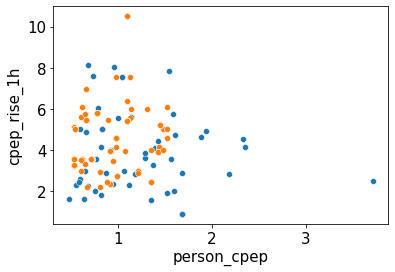

In [79]:
# Plot some exploratory scatter plots
sns.scatterplot(df_uk.person_cpep, df_uk.cpep_rise_1h)
sns.scatterplot(df_us.person_cpep, df_us.cpep_rise_1h)

/home/masoom/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/masoom/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='person_trig', ylabel='trig_rise_6h'>

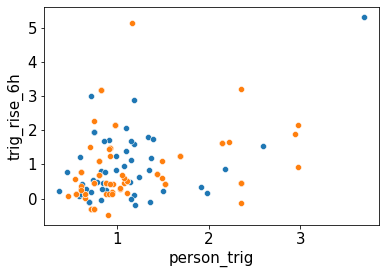

In [80]:
sns.scatterplot(df_uk.person_trig, df_uk.trig_rise_6h)
sns.scatterplot(df_us.person_trig, df_us.trig_rise_6h)

In [81]:
def plot_val_set(x, y, n):
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(figsize=(5,5))
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = np.min(y)
    y_max = np.max(y)
    b_min = np.min([x_min, y_min])
    b_max = np.max([x_max, y_max])
    sns.scatterplot(y=y,
                    x=x,
                    ax=ax)
    ax.set_xlim(b_min, b_max)
    ax.set_ylim(b_min, b_max)
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    rval, pval = scipy.stats.pearsonr(x, y)
    ax.annotate(f'R = {rval:0.2}', xy=(0.095, 0.9), xycoords='axes fraction')
    ax.annotate(f'p = {pval:0.2e}', xy=(0.1, 0.85), xycoords='axes fraction', fontsize=12)
    ax.annotate(f'n = {n}', xy=(0.1, 0.8), xycoords='axes fraction', fontsize=12)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.axhline(y=0, color='k', alpha=0.1)
    ax.axvline(x=0, color='k', alpha=0.1)

In [82]:
def plot_bland_altman(yp, y):
    xx = (yp + y)/2
    yy =  yp - y

    m_th = yy.mean()
    u_th = np.quantile(yy, 0.975)
    uu_th = yy.std()*1.96

    l_th = np.quantile(yy, 0.025)
    ll_th = - yy.std()*1.96

    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(y=yy, x=xx, ax=ax)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.axhline(y=uu_th, color='k', alpha=0.25)
    ax.axhline(y=m_th, color='k', alpha=1)
    ax.axhline(y=ll_th, color='k', alpha=0.25)


# Trig Prediction

In [96]:


# Getting the necessary features
features_num = ANTHROPOMETRY + CLINICAL_BIOCHEMESTRY + AGE + [col for col in df_clean.columns if col.startswith('mb_pca_')]
features_cat = SEX
features = features_num + features_cat
target = ['trig_rise_6h']
df = df_uk.replace([np.inf, -np.inf], np.nan).loc[:, features+target+['person_username']].drop_duplicates().dropna(subset=target)
df_val = df_us.replace([np.inf, -np.inf], np.nan).loc[:, features+target+['person_username']].drop_duplicates().dropna(subset=target)
print('In UK:', len(df))
print('In US:', len(df_val))
print('In UK:', len(df.person_username.unique()))
print('In US:', len(df_val.person_username.unique()))

preprop_num = [('imputer', SimpleImputer(strategy='mean')),
              ]
preprop_cat = [('encode', OneHotEncoder())]
pipe = [('preprocess', ColumnTransformer(transformers=[('num', Pipeline(preprop_num), features_num),
                                                       ('cat', Pipeline(preprop_cat), features_cat)])),
        ('regression', RandomForestRegressor(n_jobs=-1, n_estimators=1000, random_state=RANDOM))]


In UK: 49
In US: 76
In UK: 46
In US: 39


In [84]:
model1 = Pipeline(pipe)

In [88]:
# Leave-One-Out cross-validation for triglyceride prediction
loo = LeaveOneOut()

scores = []
y_true = []
y_pred = []

# Get the indices for splitting
indices = np.arange(len(df))

for train_index, test_index in loo.split(indices):
    # Keep as DataFrames
    X_train = df.loc[df.index[train_index], features]
    y_train = df.loc[df.index[train_index], target].values.ravel()
    
    X_test = df.loc[df.index[test_index], features]
    y_test = df.loc[df.index[test_index], target].values.ravel()
    
    # Fit the model
    model1.fit(X_train, y_train)
    
    # Predict
    pred = model1.predict(X_test)
    
    # Collect results
    y_true.append(y_test)
    y_pred.append(pred)

# Concatenate results
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print('Leave-one-out Pearson R: {} p-val: {}'.format(*scipy.stats.pearsonr(y_true, y_pred)))

Leave-one-out Pearson R: 0.13289701367036122 p-val: 0.36265877072025104


In [90]:
# K-Fold cross-validation for triglyceride prediction
kf = KFold(n_splits=5, random_state=RANDOM, shuffle=True)

In [91]:
scores = []
y = []
yp = []
for train_index, test_index in kf.split(df):
    model1.fit(df.loc[:, features].iloc[train_index, :],
               df.loc[:, target].iloc[train_index, :].values.ravel())
    scores.append(pearsonr_scorer(model1,
                                  df.loc[:, features].iloc[test_index, :],
                                  df.loc[:, target].iloc[test_index, :].values.ravel()))
    y.append(df.loc[:, target].iloc[test_index, :].values.ravel())
    yp.append(model1.predict(df.loc[:, features].iloc[test_index, :]))
y=np.concatenate(y)
yp=np.concatenate(yp)

print('mean:', np.mean(scores))
print('std:', np.std(scores))

mean: -0.0954327107765115
std: 0.3632390885542841


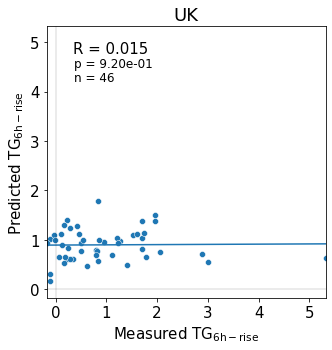

In [92]:
# Plot triglyceride training results
plot_val_set(y, yp, len(df.person_username.unique()))
plt.ylabel('$\\mathregular{Predicted\\ TG_{6h-rise}}$')
plt.xlabel('$\\mathregular{Measured\\ TG_{6h-rise}}$')
plt.title('UK')
plt.savefig('4al.svg', format='svg', bbox_inches='tight')


Text(0.5, 1.0, 'UK')

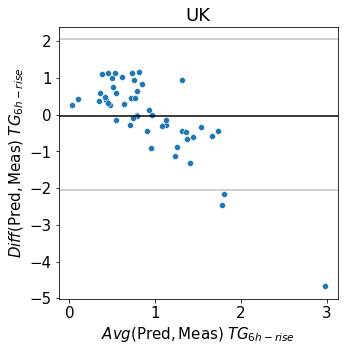

In [93]:

plot_bland_altman(yp, y)
plt.ylabel('$Diff(\\mathregular{Pred},\\mathregular{Meas}) \\; TG_{6h-rise}$')
plt.xlabel('$Avg(\\mathregular{Pred}, \\mathregular{Meas}) \\; TG_{6h-rise}$')
plt.title('UK')

In [98]:
# Train on UK data, test on US data for triglyceride prediction
model1.fit(df.loc[:, features],
          df.loc[:, target].values.ravel())
pearsonr_scorer(model1,
                df_val.loc[:, features],
                df_val.loc[:, target].values.ravel())

# Bootstrap validation for triglyceride prediction
bscore(model1,
       df_val.loc[:, features],
       df_val.loc[:, target].values.ravel())


  0%|          | 0/100 [00:00<?, ?it/s]

mean pearson R: -0.14002539985906992
std  pearson R: 0.09795435834415848


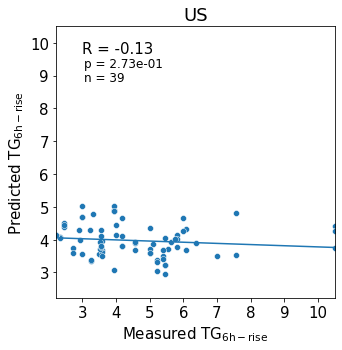

In [99]:
# Plot triglyceride validation results
x = df_val.loc[:, target].values.ravel()
y = model1.predict(df_val.loc[:, features])
plot_val_set(x, y, len(df_val.person_username.unique()))
plt.ylabel('$\\mathregular{Predicted\\ TG_{6h-rise}}$')
plt.xlabel('$\\mathregular{Measured\\ TG_{6h-rise}}$')
plt.title(f'US')
plt.savefig('4ar.svg', format='svg', bbox_inches='tight')

Text(0.5, 1.0, 'US')

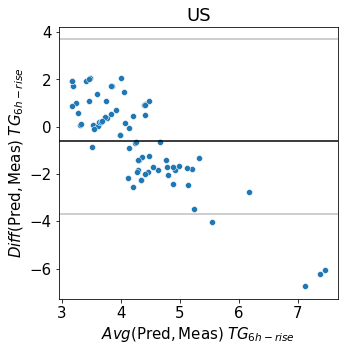

In [100]:
plot_bland_altman(y, x)
plt.ylabel('$Diff(\\mathregular{Pred},\\mathregular{Meas}) \\; TG_{6h-rise}$')
plt.xlabel('$Avg(\\mathregular{Pred}, \\mathregular{Meas}) \\; TG_{6h-rise}$')
plt.title(f'US')

# CPEP Prediction

In [101]:


# Getting the necessary features
features_num = ANTHROPOMETRY + CLINICAL_BIOCHEMESTRY + AGE + [col for col in df_clean.columns if col.startswith('mb_pca_')]
features_cat = SEX
features = features_num + features_cat
target = ['cpep_rise_1h']
df = df_uk.replace([np.inf, -np.inf], np.nan).loc[:, features+target+['person_username']].drop_duplicates().dropna(subset=target)
df_val = df_us.replace([np.inf, -np.inf], np.nan).loc[:, features+target+['person_username']].drop_duplicates().dropna(subset=target)
print('In UK:', len(df))
print('In US:', len(df_val))
print('In UK:', len(df.person_username.unique()))
print('In US:', len(df_val.person_username.unique()))

preprop_num = [('imputer', SimpleImputer(strategy='mean')),
              ]
preprop_cat = [('encode', OneHotEncoder())]
pipe = [('preprocess', ColumnTransformer(transformers=[('num', Pipeline(preprop_num), features_num),
                                                       ('cat', Pipeline(preprop_cat), features_cat)])),
        ('regression', RandomForestRegressor(n_jobs=-1, n_estimators=1000, random_state=RANDOM))]

model2 = Pipeline(pipe)

In UK: 51
In US: 76
In UK: 48
In US: 39


In [102]:
# Leave-One-Out cross-validation for C-peptide prediction
loo = LeaveOneOut()
y = []
yp = []
for train_index, test_index in loo.split(df):
    model2.fit(df.loc[:, features].iloc[train_index, :],
               df.loc[:, target].iloc[train_index, :].values.ravel())
    y.append(df.loc[:, target].iloc[test_index, :].values.ravel())
    yp.append(model2.predict(df.loc[:, features].iloc[test_index, :]))
y=np.concatenate(y)
yp=np.concatenate(yp)

print('Leave-one-out Pearson R: {} p-val: {}'.format(*scipy.stats.pearsonr(y,yp)))

Leave-one-out Pearson R: -0.09266868930941219 p-val: 0.5177780201968905


In [103]:
# K-Fold cross-validation for C-peptide prediction
kf = KFold(n_splits=5, random_state=RANDOM, shuffle=True)
scores = []
y = []
yp = []
for train_index, test_index in kf.split(df):
    model2.fit(df.loc[:, features].iloc[train_index, :],
               df.loc[:, target].iloc[train_index, :].values.ravel())
    scores.append(pearsonr_scorer(model2,
                                  df.loc[:, features].iloc[test_index, :],
                                  df.loc[:, target].iloc[test_index, :].values.ravel()))
    y.append(df.loc[:, target].iloc[test_index, :].values.ravel())
    yp.append(model2.predict(df.loc[:, features].iloc[test_index, :]))
y=np.concatenate(y)
yp=np.concatenate(yp)

print('mean:', np.mean(scores))
print('std:', np.std(scores))

mean: 0.07873926334752364
std: 0.2875089083702696


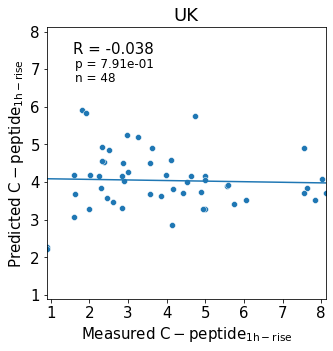

In [106]:
# Plot C-peptide training results
plot_val_set(y, yp, len(df.person_username.unique()))
plt.ylabel('$\\mathregular{Predicted\\ C-peptide_{1h-rise}}$')
plt.xlabel('$\\mathregular{Measured\\ C-peptide_{1h-rise}}$')
plt.title(f'UK')
plt.savefig('4cl.svg', format='svg', bbox_inches='tight')

Text(0.5, 1.0, 'UK')

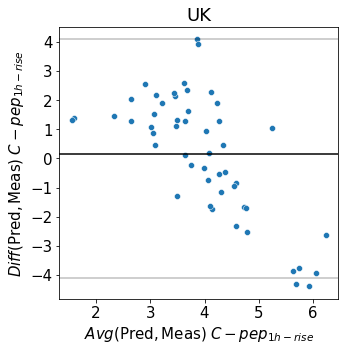

In [107]:
plot_bland_altman(yp, y)
plt.ylabel('$Diff(\\mathregular{Pred},\\mathregular{Meas}) \\; C-pep_{1h-rise}}$')
plt.xlabel('$Avg(\\mathregular{Pred}, \\mathregular{Meas}) \\; C-pep_{1h-rise}}$')
plt.title('UK')

In [108]:
# Train on UK data, test on US data for C-peptide prediction
model2.fit(df.loc[:, features],
          df.loc[:, target].values.ravel())
pearsonr_scorer(model2,
                df_val.loc[:, features],
                df_val.loc[:, target].values.ravel())

-0.12735218331351245

In [109]:
# Bootstrap validation for C-peptide prediction
bscore(model2,
       df_val.loc[:, features],
       df_val.loc[:, target].values.ravel())


  0%|          | 0/100 [00:00<?, ?it/s]

mean pearson R: -0.1400253998590699
std  pearson R: 0.09795435834415848


# GLUCOSE Prediction

In [111]:
# Function to add calibration meals
def add_cal_meal(df_in):
    def add_ogtt(df):
        avg_ogtt = df[df.meal_set_meal.isin(['Meal CC'])].meal_iauc.mean()
        dfr = df[~df.meal_set_meal.isin(['Meal CC'])]
        dfr['cal_iauc'] = avg_ogtt
        return dfr
    return df_in.groupby('person_username').apply(add_ogtt)

In [112]:
# Getting the necessary features
features_num = ANTHROPOMETRY + CLINICAL_BIOCHEMESTRY + AGE + MEAL_CONTEXT + MEAL_CONTENT + [col for col in df_clean.columns if col.startswith('mb_pca_')]
features_cat = SEX
features = features_num + features_cat
target = ['meal_iauc']
# Using only set meals
dfc_uk = add_cal_meal(df_uk)
dfc_us = add_cal_meal(df_us)
df = dfc_uk[dfc_uk.meal_has_set_meal].replace([np.inf, -np.inf], np.nan).loc[:, features+target+['cal_iauc', 'person_username']].drop_duplicates().dropna(subset=target)
df_val = dfc_us[dfc_us.meal_has_set_meal].replace([np.inf, -np.inf], np.nan).loc[:, features+target+['cal_iauc', 'person_username']].drop_duplicates().dropna(subset=target)
print('In UK:', len(df))
print('In US:', len(df_val))
print('In UK:', len(df.person_username.unique()))
print('In US:', len(df_val.person_username.unique()))

preprop_num = [('imputer', SimpleImputer(strategy='mean')),
              ]
preprop_cat = [('encode', OneHotEncoder())]
pipe = [('preprocess', ColumnTransformer(transformers=[('num', Pipeline(preprop_num), features_num+['cal_iauc']),
                                                       ('cat', Pipeline(preprop_cat), features_cat)])),
        ('regression', RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=RANDOM))]

model3 = Pipeline(pipe)


In UK: 22
In US: 39
In UK: 22
In US: 20


In [113]:
# Leave-One-Group-Out cross-validation for glucose prediction
loo = LeaveOneGroupOut().split(df.loc[:, 'person_username'], groups=df.loc[:, 'person_username'])
scores = []
y = []
yp = []
for train_index, test_index in loo:
    model3.fit(df.loc[:, features+['cal_iauc']].iloc[train_index, :],
               df.loc[:, target].iloc[train_index, :].values.ravel())
    y.append(df.loc[:, target].iloc[test_index, :].values.ravel())
    yp.append(model3.predict(df.loc[:, features+['cal_iauc']].iloc[test_index, :]))
y=np.concatenate(y)
yp=np.concatenate(yp)

print('Leave-one-out Pearson R: {} p-val: {}'.format(*scipy.stats.pearsonr(y,yp)))

Leave-one-out Pearson R: -0.35652102547239145 p-val: 0.10338594902220376


In [62]:
# Group K-Fold cross-validation for glucose prediction
kf = GroupKFold(n_splits=5).split(df.loc[:, 'person_username'], groups=df.loc[:, 'person_username'])
scores = []
y = []
yp = []
for train_index, test_index in kf:
    model3.fit(df.loc[:, features+['cal_iauc']].iloc[train_index, :],
               df.loc[:, target].iloc[train_index, :].values.ravel())
    scores.append(pearsonr_scorer(model3,
                                  df.loc[:, features+['cal_iauc']].iloc[test_index, :],
                                  df.loc[:, target].iloc[test_index, :].values.ravel()))
    y.append(df.loc[:, target].iloc[test_index, :].values.ravel())
    yp.append(model3.predict(df.loc[:, features+['cal_iauc']].iloc[test_index, :]))
y=np.concatenate(y)
yp=np.concatenate(yp)

print('mean:', np.mean(scores))
print('std:', np.std(scores))


mean: -0.296308962137992
std: 0.4246963870522056


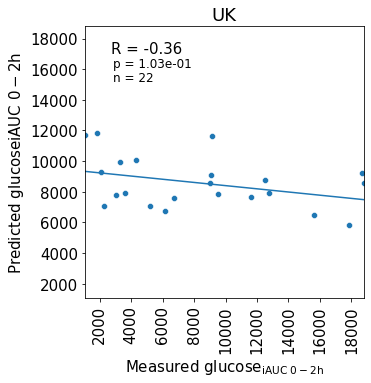

In [114]:
# Plot glucose training results
plot_val_set(y, yp, len(df.person_username.unique()))
plt.ylabel('$\\mathregular{Predicted\\ glucose{iAUC\\ 0-2h}}$')
plt.xlabel('$\\mathregular{Measured\\ glucose_{iAUC\\ 0-2h}}$')
plt.title(f'UK')
plt.xticks(rotation=90)
plt.savefig('4bl.svg', format='svg', bbox_inches='tight')



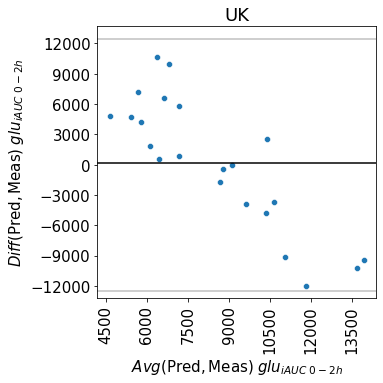

In [115]:
plot_bland_altman(yp, y)
plt.ylabel('$Diff(\\mathregular{Pred},\\mathregular{Meas}) \\; glu_{iAUC\\ 0-2h}}$')
plt.xlabel('$Avg(\\mathregular{Pred}, \\mathregular{Meas}) \\; glu_{iAUC\\ 0-2h}}$')
plt.title(f'UK')
plt.xticks(rotation=90)
plt.show()

In [116]:
# Train on UK data, test on US data for glucose prediction
model3.fit(df.loc[:, features+['cal_iauc']],
          df.loc[:, target].values.ravel())
pearsonr_scorer(model3,
                df_val.loc[:, features+['cal_iauc']],
                df_val.loc[:, target].values.ravel())

# Bootstrap validation for glucose prediction
bscore(model3,
       df_val.loc[:, features+['cal_iauc']],
       df_val.loc[:, target].values.ravel())


  0%|          | 0/100 [00:00<?, ?it/s]

mean pearson R: 0.09973133429913388
std  pearson R: 0.15780686070448924


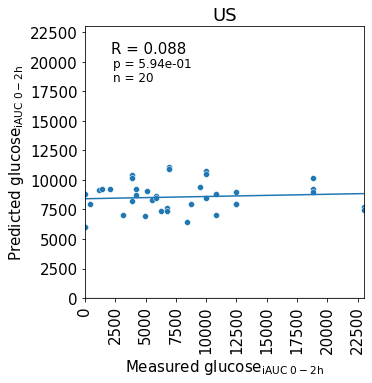

In [117]:
# Plot glucose validation results
x = df_val.loc[:, target].values.ravel()
y = model3.predict(df_val.loc[:, features+['cal_iauc']])
plot_val_set(x, y, len(df_val.person_username.unique()))
plt.ylabel('$\\mathregular{Predicted\\ glucose_{iAUC\\ 0-2h}}$')
plt.xlabel('$\\mathregular{Measured\\ glucose_{iAUC\\ 0-2h}}$')
plt.title(f'US')
plt.xticks(rotation=90)
plt.savefig('4br.svg', format='svg', bbox_inches='tight')

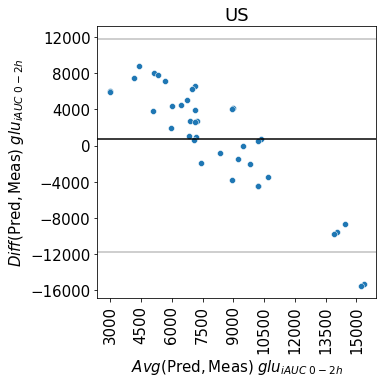

In [118]:
plot_bland_altman(y, x)
plt.ylabel('$Diff(\\mathregular{Pred},\\mathregular{Meas}) \\; glu_{iAUC\\ 0-2h}}$')
plt.xlabel('$Avg(\\mathregular{Pred}, \\mathregular{Meas}) \\; glu_{iAUC\\ 0-2h}}$')
plt.title(f'US')
plt.xticks(rotation=90)
plt.show()